In [1]:
import os
import csv
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    cross_val_score,
    cross_val_predict
)

In [56]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [36]:
from scipy.stats import pearsonr, ttest_ind,spearmanr

# CONFIG
data_csv = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/df_with_cognition_and_ages.csv"
base_path = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/"
region_confidence_files = ["FCMpost-SpC_right_28-32_new_confidences.csv","SFinf-BROCA-SPeCinf_left_28-32_new_confidences.csv","STs_right_28-32_new_confidences.csv","STi-STs-STpol_right_28-32_new_confidences.csv","FCLp-subsc-FCLa-INSULA_right_28-32_new_confidences.csv","FColl-SRh_right_28-32_new_confidences.csv","STi-SOTlat_right_28-32_new_confidences.csv"] 
region_list = ["FCMpost-SpC_right", "SFinf-BROCA-SPeCinf_left", "STs_right", "STi-STs-STpol_right", "FCLp-subsc-FCLa-INSULA_right","FColl-SRh_right","STi-SOTlat_right"]
ga_col = "gest_age"        
prem_binary_col = "devhx_12a_p"  # 1 = préma, 0 = terme
out_csv = "prematurity_pearson_28_32.csv"

scores = [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]

df = pd.read_csv(data_csv)
df[prem_binary_col] = df[prem_binary_col].astype(int)
print("Loaded:", df.shape)


for file,region  in zip(region_confidence_files,region_list):
    confidence_df_path = os.path.join(base_path, file)
    confidence_df = pd.read_csv(confidence_df_path)[["src_subject_id", "proba_premature"]]
    df = df.merge(
        confidence_df,
        left_on='src_subject_id', right_on='src_subject_id', how='left'
    )
    df = df.rename(columns={'proba_premature': region + '_confidence'})
    
#Cohen's d
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mx, my = np.mean(x), np.mean(y)
    sx2, sy2 = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    if pooled == 0 or np.isnan(pooled):
        return np.nan
    return (mx - my) / pooled

rows = []
for region in region_list: 
    for score in scores:
        conf_col = f"{region}_confidence"
        print(df.columns)
        sub_all = df[[conf_col, score]].dropna()
        print(df["prem_class"].value_counts())

        # pour le sous-groupe prem_small (28-32 et 32-37)
        sub_pre_small = df[df["prem_class"].isin(["28-32"])][[conf_col, score]].dropna()

        # pearson on alldf
        r_pre_small, p_pre_small = spearmanr(sub_pre_small[conf_col], sub_pre_small[score])

        r_row = {
        'region': region,
        'score': score,
        'spearman_r_pre_small': float(r_pre_small) if not np.isnan(r_pre_small) else np.nan,
        'spearman_p_pre_small': float(p_pre_small) if not np.isnan(p_pre_small) else np.nan,
        'n_pre_small': int(sub_pre_small.shape[0])
        }
        rows.append(r_row)


res_df = pd.DataFrame(rows)
res_df.to_csv(out_csv, index=False)
print("Saved summary to", out_csv)


Loaded: (9856, 14)
Index(['src_subject_id', 'devhx_12a_p', 'devhx_12_p', 'gest_age', 'prem_class',
       'nihtbx_flanker_agecorrected', 'nihtbx_cardsort_agecorrected',
       'nihtbx_list_agecorrected', 'nihtbx_pattern_agecorrected',
       'nihtbx_picvocab_agecorrected', 'nihtbx_reading_agecorrected',
       'nihtbx_fluidcomp_agecorrected', 'nihtbx_cryst_agecorrected',
       'nihtbx_totalcomp_agecorrected', 'FCMpost-SpC_right_confidence',
       'SFinf-BROCA-SPeCinf_left_confidence', 'STs_right_confidence',
       'STi-STs-STpol_right_confidence',
       'FCLp-subsc-FCLa-INSULA_right_confidence', 'FColl-SRh_right_confidence',
       'STi-SOTlat_right_confidence'],
      dtype='object')
prem_class
>=37     8532
32-37    1202
28-32      85
<28        37
Name: count, dtype: int64
Index(['src_subject_id', 'devhx_12a_p', 'devhx_12_p', 'gest_age', 'prem_class',
       'nihtbx_flanker_agecorrected', 'nihtbx_cardsort_agecorrected',
       'nihtbx_list_agecorrected', 'nihtbx_pattern_agecorre

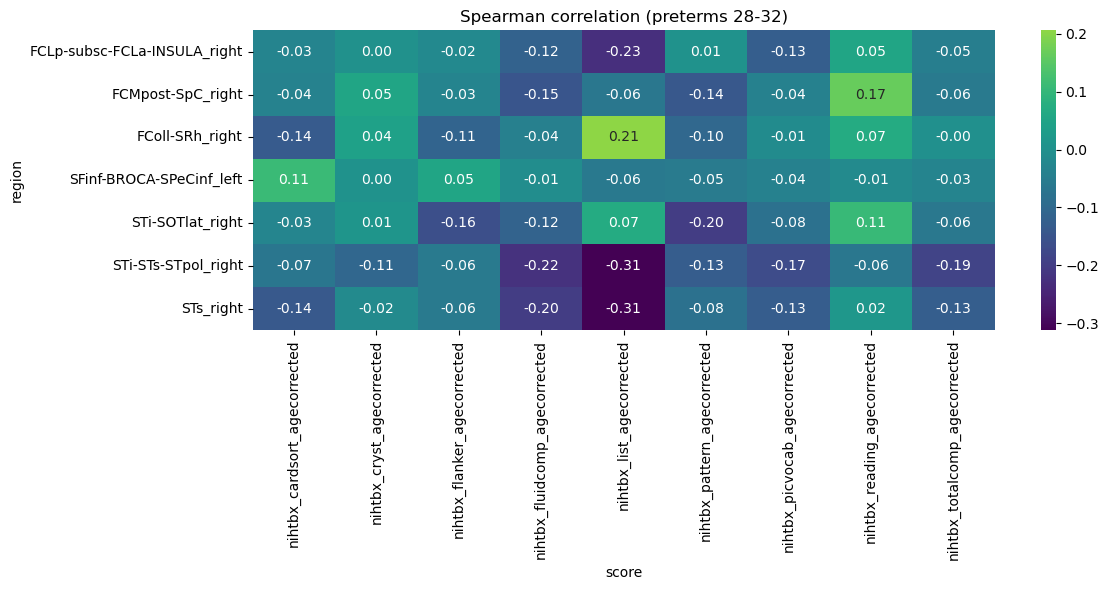

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#  Charger le CSV
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_pearson_28_32.csv")

# On pivote pour avoir une matrice (région en lignes, score en colonnes)
heatmap_data = df.pivot(index="region", columns="score", values="spearman_r_pre_small")

# On trace la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", center=0, fmt=".2f")
plt.title("Spearman correlation (preterms 28-32)")
plt.tight_layout()
plt.show()


In [26]:
# CONFIG
data_csv = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/df_with_cognition_and_ages.csv"
base_path = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/"
region_confidence_files = ["FCMpost-SpC_right_32-37_new_confidences.csv","SFinf-BROCA-SPeCinf_left_32-37_new_confidences.csv","STs_right_32-37_new_confidences.csv","STi-STs-STpol_right_32-37_new_confidences.csv","FCLp-subsc-FCLa-INSULA_right_32-37_new_confidences.csv"] 
region_list = ["FCMpost-SpC_right", "SFinf-BROCA-SPeCinf_left", "STs_right", "STi-STs-STpol_right", "FCLp-subsc-FCLa-INSULA_right"]
ga_col = "gest_age"        
prem_binary_col = "devhx_12a_p"  # 1 = préma, 0 = terme
out_csv = "prematurity_pearson_32_37.csv"

scores = [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]

df = pd.read_csv(data_csv)
df[prem_binary_col] = df[prem_binary_col].astype(int)
print("Loaded:", df.shape)


for file,region  in zip(region_confidence_files,region_list):
    confidence_df_path = os.path.join(base_path, file)
    confidence_df = pd.read_csv(confidence_df_path)[["src_subject_id", "proba_premature"]]
    df = df.merge(
        confidence_df,
        left_on='src_subject_id', right_on='src_subject_id', how='left'
    )
    df = df.rename(columns={'proba_premature': region + '_confidence'})
    
#Cohen's d
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mx, my = np.mean(x), np.mean(y)
    sx2, sy2 = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    if pooled == 0 or np.isnan(pooled):
        return np.nan
    return (mx - my) / pooled

rows = []
for region in region_list: 
    for score in scores:
        conf_col = f"{region}_confidence"
        print(df.columns)
        sub_all = df[[conf_col, score]].dropna()
        print(df["prem_class"].value_counts())

        # pour le sous-groupe prem_small (32-37)
        sub_pre_small = df[df["prem_class"].isin(["32-37"])][[conf_col, score]].dropna()

        # pearson on alldf
        r_pre_small, p_pre_small = spearmanr(sub_pre_small[conf_col], sub_pre_small[score])

        r_row = {
        'region': region,
        'score': score,
        'spearman_r_pre_small': float(r_pre_small) if not np.isnan(r_pre_small) else np.nan,
        'spearman_p_pre_small': float(p_pre_small) if not np.isnan(p_pre_small) else np.nan,
        'n_pre_small': int(sub_pre_small.shape[0])
        }
        rows.append(r_row)


res_df = pd.DataFrame(rows)
res_df.to_csv(out_csv, index=False)
print("Saved summary to", out_csv)

Loaded: (9856, 14)
Index(['src_subject_id', 'devhx_12a_p', 'devhx_12_p', 'gest_age', 'prem_class',
       'nihtbx_flanker_agecorrected', 'nihtbx_cardsort_agecorrected',
       'nihtbx_list_agecorrected', 'nihtbx_pattern_agecorrected',
       'nihtbx_picvocab_agecorrected', 'nihtbx_reading_agecorrected',
       'nihtbx_fluidcomp_agecorrected', 'nihtbx_cryst_agecorrected',
       'nihtbx_totalcomp_agecorrected', 'FCMpost-SpC_right_confidence',
       'SFinf-BROCA-SPeCinf_left_confidence', 'STs_right_confidence',
       'STi-STs-STpol_right_confidence',
       'FCLp-subsc-FCLa-INSULA_right_confidence'],
      dtype='object')
prem_class
>=37     8532
32-37    1202
28-32      85
<28        37
Name: count, dtype: int64
Index(['src_subject_id', 'devhx_12a_p', 'devhx_12_p', 'gest_age', 'prem_class',
       'nihtbx_flanker_agecorrected', 'nihtbx_cardsort_agecorrected',
       'nihtbx_list_agecorrected', 'nihtbx_pattern_agecorrected',
       'nihtbx_picvocab_agecorrected', 'nihtbx_reading_agecor

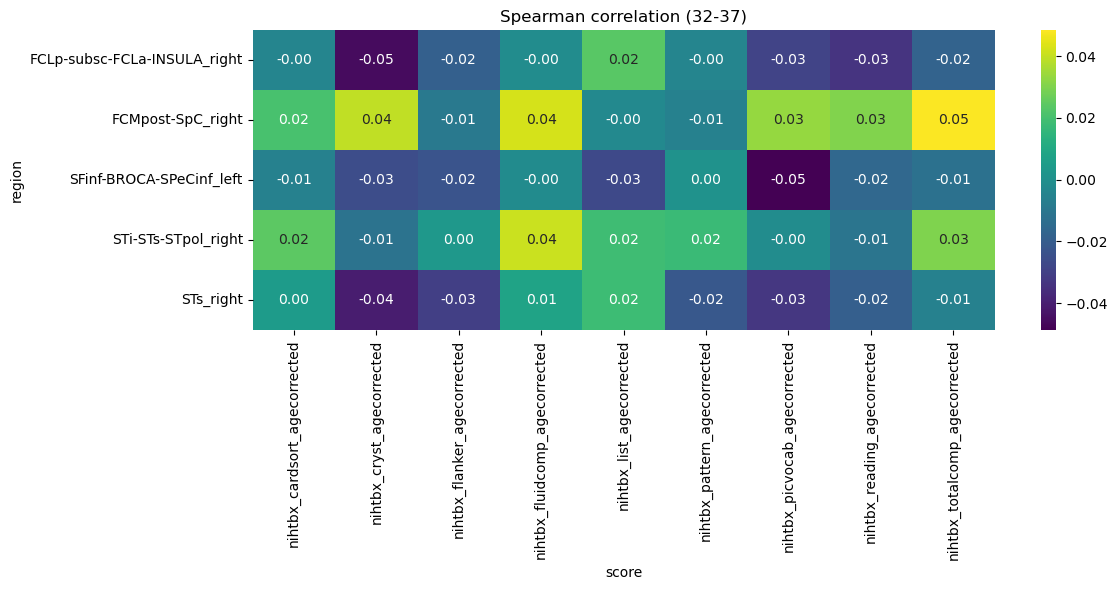

In [31]:
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_pearson_32_37.csv")

# Matrice des corrélations (Spearman r)
heatmap_r = df.pivot(index="region", columns="score", values="spearman_r_pre_small")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_r, annot=True, cmap="viridis", center=0, fmt=".2f")
plt.title("Spearman correlation (32-37)")
plt.tight_layout()
plt.show()

